In [1]:
from draw import draw_attention

/home/jieun/RocksDB_DATA/test_notebook/draw.py:38: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (data[i]==1).nonzero().squeeze().cpu().detach().numpy()


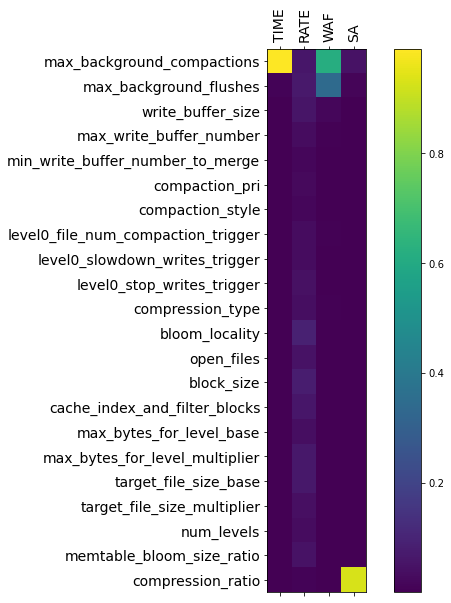

In [2]:
config = '-max_background_compactions=1 -max_background_flushes=4 -write_buffer_size=2044928 -max_write_buffer_number=8 -min_write_buffer_number_to_merge=2 -compaction_pri=0 -compaction_style=0 -level0_file_num_compaction_trigger=5 -level0_slowdown_writes_trigger=17 -level0_stop_writes_trigger=64 -compression_type=lz4 -bloom_locality=0 -open_files=1000000 -block_size=8192 -cache_index_and_filter_blocks=0 -max_bytes_for_level_base=8388608 -max_bytes_for_level_multiplier=11 -target_file_size_base=2088960 -target_file_size_multiplier=2 -num_levels=8 -memtable_bloom_size_ratio=0 -compression_ratio=0'
target = 16
similar_wk = 1
model_path = '20211007/model-20211007-08.pt'

model = draw_attention(config=config, target=target, similar_wk=similar_wk, model_path=model_path, save_path='wk16.pdf')

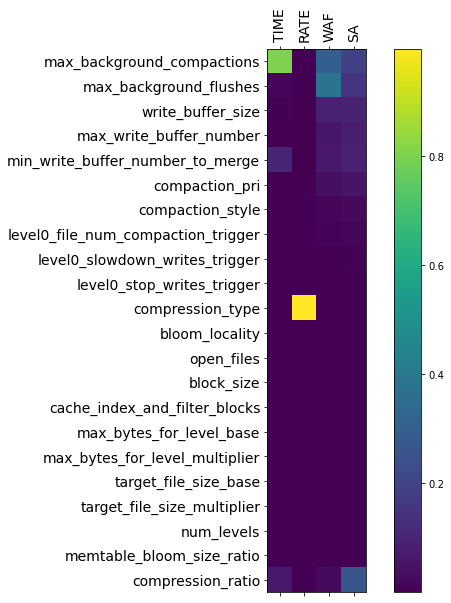

In [3]:
config = '-max_background_compactions=3 -max_background_flushes=8 -write_buffer_size=2088960 -max_write_buffer_number=7 -min_write_buffer_number_to_merge=2 -compaction_pri=3 -compaction_style=0 -level0_file_num_compaction_trigger=3 -level0_slowdown_writes_trigger=31 -level0_stop_writes_trigger=52 -compression_type=zlib -bloom_locality=0 -open_files=100000 -block_size=10240 -cache_index_and_filter_blocks=1 -max_bytes_for_level_base=8388608 -max_bytes_for_level_multiplier=11 -target_file_size_base=728064 -target_file_size_multiplier=1 -num_levels=5 -memtable_bloom_size_ratio=0 -compression_ratio=0'
target = 17
similar_wk = 6
model_path = '20211006/model-20211006-123.pt'

model = draw_attention(config=config, target=target, similar_wk=similar_wk, model_path=model_path, save_path='wk17.pdf')

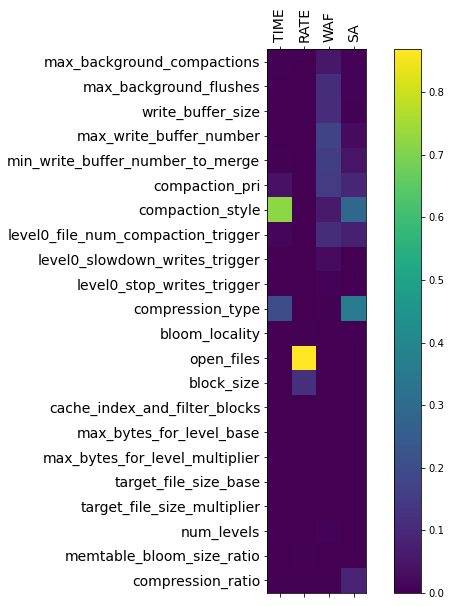

In [4]:
config = '-max_background_compactions=3 -max_background_flushes=8 -write_buffer_size=1995776 -max_write_buffer_number=8 -min_write_buffer_number_to_merge=2 -compaction_pri=3 -compaction_style=0 -level0_file_num_compaction_trigger=8 -level0_slowdown_writes_trigger=20 -level0_stop_writes_trigger=49 -compression_type=lz4 -bloom_locality=1 -open_files=-1 -block_size=14336 -cache_index_and_filter_blocks=0 -max_bytes_for_level_base=7340032 -max_bytes_for_level_multiplier=11 -target_file_size_base=1210368 -target_file_size_multiplier=1 -num_levels=7 -memtable_bloom_size_ratio=0 -compression_ratio=0'
target = 18
similar_wk = 14
model_path = '20211007/model-20211007-30.pt'

model = draw_attention(config=config, target=target, similar_wk=similar_wk, model_path=model_path, save_path='wk18.pdf')